In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# using scipy environment to generate samples because it has updated scipy with vonmises_fisher
import numpy as np
from scipy.stats import vonmises_fisher

## Generate synthetic bimodal distribution on a sphere

In [4]:
angle_pairs = np.load('/home/brysongray/fibermetric/outputs/sta_validate_outputs/angle_pairs.npy')
rng = np.random.default_rng()

samples = np.empty((100, 5000, 3), dtype=np.float64)
centers = np.empty((100, 2, 3), dtype=np.float64)
# random_uniform = np.random.uniform(low=-1.0, high=1.0, size=(1000,3))
# random_uniform = random_uniform / np.linalg.norm(random_uniform, axis=1)[:,None]
for i,p in enumerate(angle_pairs):
    u = np.array([np.cos(p[0,0]),np.sin(p[0,0])*np.cos(p[0,1]),np.sin(p[0,0])*np.sin(p[0,1])])
    v = np.array([np.cos(p[1,0]),np.sin(p[1,0])*np.cos(p[1,1]),np.sin(p[1,0])*np.sin(p[1,1])])
    sample1 = vonmises_fisher(u, 10).rvs(1250, random_state=rng)
    sample2 = vonmises_fisher(-u, 10).rvs(1250, random_state=rng)
    sample3 = vonmises_fisher(v, 10).rvs(1250, random_state=rng)
    sample4 = vonmises_fisher(-v, 10).rvs(1250, random_state=rng)
    # sample = np.concatenate((sample1,sample2,random_uniform),axis=0)
    sample = np.concatenate((sample1,sample2, sample3, sample4),axis=0)
    centers[i] = np.array([u,v])
    samples[i] = sample

np.savez('/home/brysongray/fibermetric/outputs/sta_validate_outputs/apsym_kmeans_test_data.npz',samples=samples, centers=centers)

In [2]:
# switch to fibermetric environment
%matplotlib widget
import os
import sys
import matplotlib.pyplot as plt
from time import time
from dipy.core.sphere import disperse_charges, HemiSphere
import torch
from torch.nn import Upsample
import scipy

from dipy.data import get_sphere
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from dipy.core.gradients import gradient_table

from fury import actor, window
from IPython.core.display import Image
from PIL import Image as PILImage

import numpy as np

sys.path.append('../fibermetric/')
import sta_validate
import histology
import apsym_kmeans
import diffusion
import utils


data = np.load('/home/brysongray/fibermetric/outputs/sta_validate_outputs/apsym_kmeans_test_data.npz')
samples = data['samples']
centers = data['centers']

## Test k-means on synthetic bimodal distribution

In [2]:
samples.shape

(100, 5000, 3)

In [3]:
rng = np.random.default_rng()
skm = apsym_kmeans.APSymKMeans(n_clusters=2, verbose=False, random_state=0, n_init=1)
diff = []
mu_list = []
for i in range(len(samples)):
    skm.fit(samples[i])
    mu = skm.cluster_centers_
    mu_list.append(mu)
    diff_ = np.empty((len(mu),len(centers[i]))) # shape (2,2) for two permutations of the difference between two means and two true_thetas
    for m in range(len(mu)):
        for n in range(len(centers[i])):
            diff_[m,n] = np.arccos(np.abs(mu[m].dot(centers[i,n])))
    argmax = np.unravel_index(np.argmin(diff_), (2,2))
    corrolary = tuple([1 - x for x in argmax]) # the corresponding cos_dif of the other mu to the other grid_theta
    diff.append(np.mean([diff_[argmax], diff_[corrolary]]) * 180/np.pi)


In [4]:
print(f'median of difference (degrees): {np.median(diff)}')
print(f'median absolute deviation (degrees): {np.median(np.abs(diff - np.median(diff)))}')
print(f'mean of difference (degrees): {np.mean(diff)}')
print(f'standard deviation (degrees): {np.std(diff)}')

median of difference (degrees): 1.087685134765222
median absolute deviation (degrees): 0.6413517349136413
mean of difference (degrees): 2.5498298804852393
standard deviation (degrees): 4.831268411217182


In [5]:
print(f'median of difference (degrees): {np.median(diff)}')
print(f'median absolute deviation (degrees): {np.median(np.abs(diff))}')
print(f'mean of difference (degrees): {np.mean(diff)}')
print(f'standard deviation (degrees): {np.std(diff)}')

median of difference (degrees): 1.087685134765222
median absolute deviation (degrees): 1.087685134765222
mean of difference (degrees): 2.5498298804852393
standard deviation (degrees): 4.831268411217182


# Visualize simulated distribution

In [3]:
# helper functions for visualization
WINDOW_SIZE = (900, 900)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)

def screenshot_animated_sf(sf, sphere, rot=True, norm=True, scale=True, title='Modeling', theta_step=30, mu=None, true_thetas=None):
    '''
    Render a spherical function to file. Returns path to image.
    '''
    
    scene = window.Scene()
    scene.background(window.colors.white)
    
    sf_actor = actor.odf_slicer(sf[None, None, None, :],
                               sphere=sphere, colormap='jet',
                               norm=norm, )#, radial_scale=scale)
    scene.add(sf_actor)

    is_mu = mu is not None
    is_true_thetas = true_thetas is not None

    if is_mu:
        mu_lines = np.array([[mu[0],-mu[0]],
                        [mu[1],-mu[1]]]) / 1.5
        mu_colors = np.array([[0,1,0],
                        [0,1,0]])
        lines = mu_lines
        colors = mu_colors

    if is_true_thetas:

        x_cart = true_thetas
        
        true_lines = np.array([[x_cart[0],-x_cart[0]],
                        [x_cart[1],-x_cart[1]]]) / 1.5
        true_colors = np.array([[0.6,0.2,0.95],
                        [0.6,0.2,0.95]])
        lines = true_lines
        colors = true_colors

    if is_mu and is_true_thetas:
            lines = np.concatenate((mu_lines, true_lines), axis=0)
            colors = np.concatenate((mu_colors, true_colors), axis=0)
    
    if is_mu or is_true_thetas:
        lines_actor = actor.line(lines, colors=colors, linewidth=3)
        scene.add(lines_actor)
        if rot:
            lines_actor.RotateX(90)
            lines_actor.RotateZ(0)
            # lines_actor.RotateY(90)

    if rot:
        sf_actor.RotateX(90)
        sf_actor.RotateZ(0)
        # sf_actor.RotateY(90)
    
    images = []
    n_frames = 360//theta_step
    for i in np.arange(n_frames):
        sf_actor.RotateZ(theta_step)
        if mu is not None:
            lines_actor.RotateZ(theta_step)

        scene.reset_clipping_range()
        images.append(PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE)))
        
    frame_duration = 20000 // theta_step
    filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
    images[0].save(filename, save_all=True, append_images=images[1:],
                  duration=frame_duration, optimize=False, loop=0)
    scene.clear()

    return filename
    
def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)

    scene.clear()
    return outfile
        

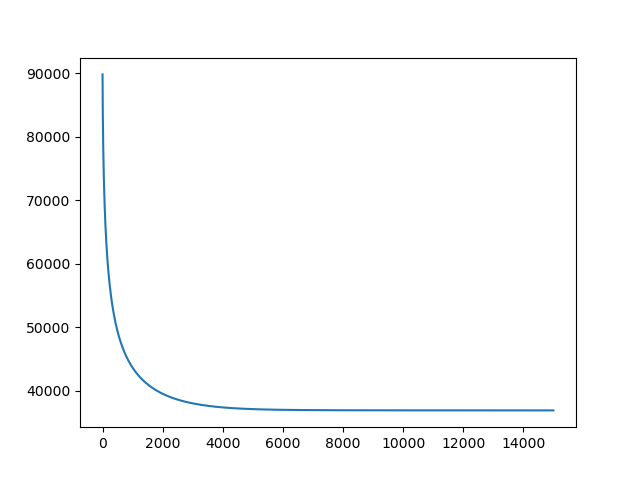

In [3]:
n_pts = 100
theta = np.pi - np.random.rand(n_pts)
phi = 2 * np.pi - np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial,15000, const=0.5)
vertices = hsph_updated.vertices
sph_gtab = Sphere(xyz=np.vstack((vertices)))
plt.figure()
plt.plot(potential)

In [8]:
v = sph_gtab.vertices
e = sph_gtab.edges
faces = sph_gtab.faces
with open('sphere.txt', 'w') as f:
    f.write('VERTICES \n')
    for i in range(len(sph_gtab.vertices)):
        f.write(f'{v[i,0]} {v[i,1]} {v[i,2]}\n')
    f.write('\nEDGES \n')
    for i in range(len(sph_gtab.edges)):
        f.write(f'{e[i,0]} {e[i,1]}\n')
    f.write('\nFACES \n')
    for i in range(len(sph_gtab.faces)):
        f.write(f'{faces[i,0]} {faces[i,1]} {faces[i,2]}\n')

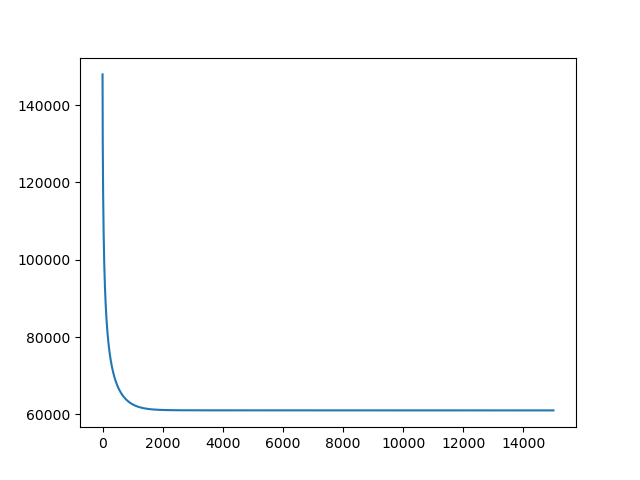

In [4]:
n_pts = 128
theta = np.pi - np.random.rand(n_pts)
phi = 2 * np.pi - np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial,15000, const=0.5)

vertices = hsph_updated.vertices
# values = np.ones(vertices.shape[0])
# bvecs = np.vstack((vertices))
# bvals = np.hstack((bvalue * values))
# # add some b=0 bvals/bvecs
# bvecs = np.insert(bvecs, (0,bvecs.shape[0]), np.array([0,0,0]), axis = 0)
# bvals = np.insert(bvals, (0, bvals.shape[0]), 0)

# gtab = gradient_table(bvals, bvecs)
sph_gtab = Sphere(xyz=np.vstack((vertices,-vertices)))

plt.figure()
plt.plot(potential)

In [5]:
# count the number of angles closest to each vertex
j=0
print(centers[j])
print(samples[j].shape)
ids = np.argmax(np.abs(samples[j] @ vertices.T), axis=1)
unique, counts = np.unique(ids, return_counts=True)
hist = np.zeros(vertices.shape[0])
hist[unique] = counts
hist_sph = np.zeros(vertices.shape[0]*2)
hist_sph[:vertices.shape[0]] = hist
hist_sph[vertices.shape[0]:] = hist


[[ 0.83063873  0.5329598   0.16122391]
 [-0.3468712  -0.39775384  0.84939523]]
(5000, 3)


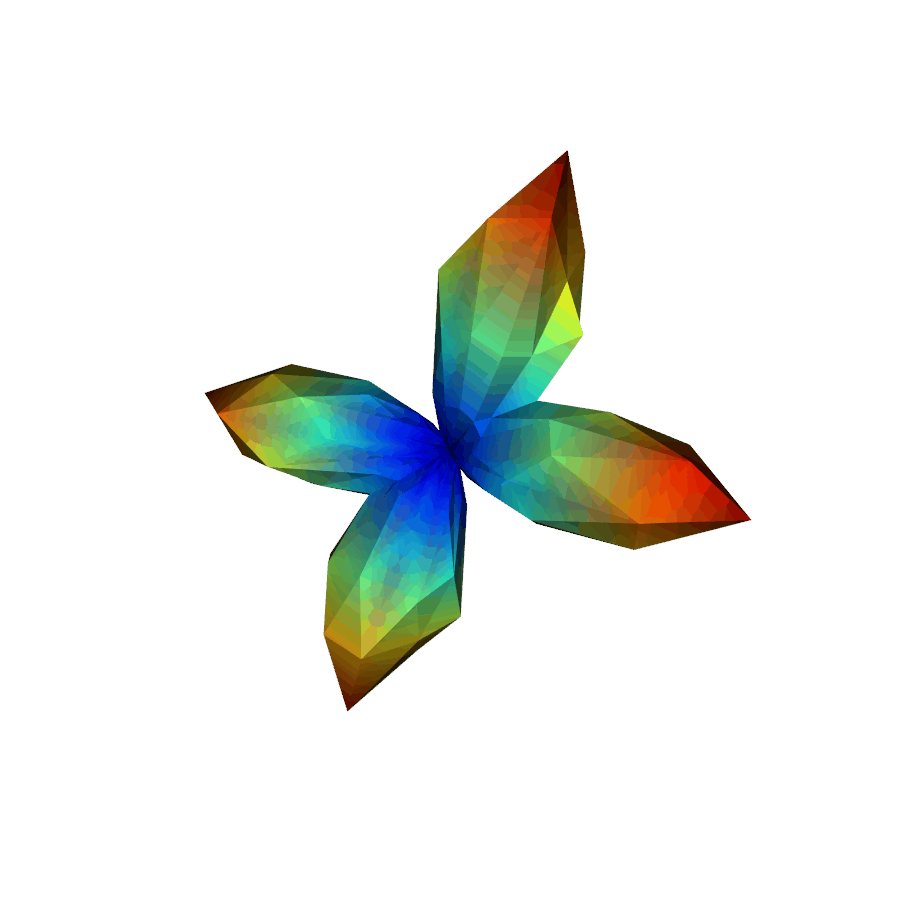

In [6]:
image = screenshot_animated_sf(hist_sph, sph_gtab, title='Histogram of STA angles', theta_step=360, rot=True, mu=None, true_thetas=None)
Image(filename=image)

## look at distribution of errors for two angle phantoms

In [11]:
# in 3D
n = (36, 72, 72)
dx = (2.0, 1.0, 1.0)
x = [np.arange(ni)*dxi for ni, dxi in zip(n, dx)]
# phantom_angles = np.load('/home/brysongray/fibermetric/outputs/sta_validate_outputs/angles.npy')
angle_pairs = np.load('/home/brysongray/fibermetric/outputs/sta_validate_outputs/angle_pairs.npy')

# phantom_angle = np.array([[2.33803817, 0.77978514],
#                           [1.39072774, 2.96977006]])
phantoms = []
phantoms_= []
for phantom_angle in angle_pairs:
    phantoms.append(sta_validate.make_phantom(x, phantom_angle, period=10.0, noise=1e-12))
    phantoms_.append(sta_validate.make_phantom(x, phantom_angle, period=10.0, noise=1e-12, blur_correction=True))

# plt.figure()
# plt.imshow(img[:,:,36])

In [12]:
skm = apsym_kmeans.APSymKMeans(n_clusters=2, n_init=1, random_state=0)


In [4]:
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=5.0, num=10)
print(derivative_sigmas)
print(tensor_sigmas)

[0.15       0.41111111 0.67222222 0.93333333 1.19444444 1.45555556
 1.71666667 1.97777778 2.23888889 2.5       ]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]


median of difference (degrees): 8.542179194876006
median absolute deviation (degrees): 3.8434162535626464
mean of difference (degrees): 13.293724437555813
standard deviation (degrees): 12.594105949876436
max: 58.18377808514134
time: 119.73146677017212 seconds


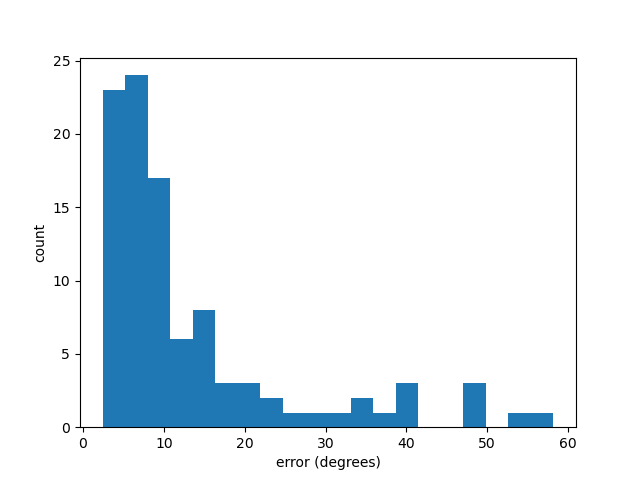

In [13]:
# fit k-means to the angles
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=5.0, num=10)
d = derivative_sigmas[4]
t = tensor_sigmas[2]

start = time()
diffs = []

for i,p in enumerate(phantoms):
    # first blur correct the phantom
    S = histology.structure_tensor(p, derivative_sigma=d, tensor_sigma=t, masked=False, normalize=True)
    angles = histology.angles(S, cartesian=True) # shape (72,72,72,3)
    crop = round(max(t,d)*8/3) # two-thirds the radius of the largest kernel
    crop_0 = crop+round(dx[0])-1
    angles = angles[crop:-crop_0, crop:-crop, crop:-crop]

    angles_ = angles.reshape(-1,3)

    # skm = apsym_kmeans.APSymKMeans(n_clusters=2, n_init=1, random_state=0)
    skm.fit(angles_)
    mu = skm.cluster_centers_

    phantom_angle = angle_pairs[i]
    true_thetas = np.array([np.sin(phantom_angle[:,0])*np.sin(phantom_angle[:,1]),
                                    np.sin(phantom_angle[:,0])*np.cos(phantom_angle[:,1]),
                                    np.cos(phantom_angle[:,0])
                                    ]).T

    diff_ = np.empty((len(mu),len(true_thetas))) # shape (2,2) for two permutations of the difference between two means and two true_thetas
    for m in range(len(mu)):
        for n in range(len(true_thetas)):
            diff_[m,n] = np.arccos(np.abs(mu[m].dot(true_thetas[n])))
    argmax = np.unravel_index(np.argmin(diff_), (2,2))
    corrolary = tuple([1 - x for x in argmax]) # the corresponding cos_dif of the other mu to the other grid_theta
    diff = np.mean([diff_[argmax], diff_[corrolary]]) * 180/np.pi
    diffs.append(diff)
end = time()

plt.figure()
plt.hist(diffs, bins=20)
plt.xlabel('error (degrees)')
plt.ylabel('count')

print(f'median of difference (degrees): {np.median(diffs)}')
print(f'median absolute deviation (degrees): {np.median(np.abs(diffs - np.median(diffs)))}')
print(f'mean of difference (degrees): {np.mean(diffs)}')
print(f'standard deviation (degrees): {np.std(diffs)}')
print(f'max: {np.max(diffs)}')
print(f'time: {end-start} seconds')

median of difference (degrees): 16.874715698162703
median absolute deviation (degrees): 6.536680971451068
mean of difference (degrees): 21.003006553022082
standard deviation (degrees): 12.952740846489714
max: 52.050216745022546
time: 166.78458642959595 seconds


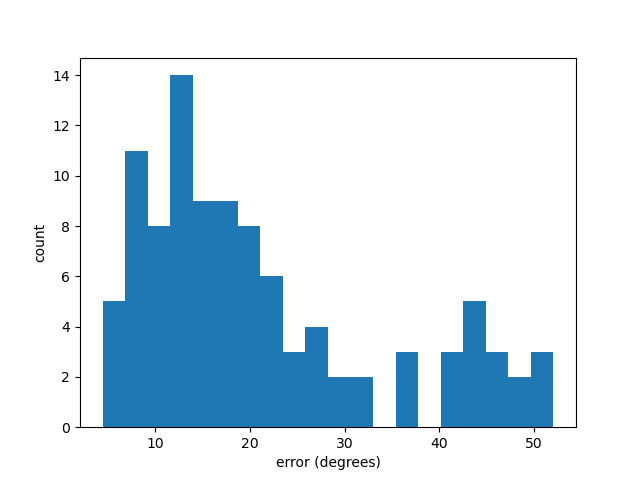

In [14]:
# fit k-means to the angles
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=5.0, num=10)
d = derivative_sigmas[4]
t = tensor_sigmas[2]

start = time()
diffs = []

for i,p in enumerate(phantoms_):
    # first blur correct the phantom
    S = histology.structure_tensor(p, derivative_sigma=d, tensor_sigma=t, masked=False, normalize=True)
    angles = histology.angles(S, cartesian=True) # shape (72,72,72,3)
    crop = round(max(t,d)*8/3) # two-thirds the radius of the largest kernel
    crop_0 = crop+round(dx[0])-1
    angles = angles[crop:-crop_0, crop:-crop, crop:-crop]

    angles_ = angles.reshape(-1,3)

    # skm = apsym_kmeans.APSymKMeans(n_clusters=2, n_init=1, random_state=0)
    skm.fit(angles_)
    mu = skm.cluster_centers_

    phantom_angle = angle_pairs[i]
    true_thetas = np.array([np.sin(phantom_angle[:,0])*np.sin(phantom_angle[:,1]),
                                    np.sin(phantom_angle[:,0])*np.cos(phantom_angle[:,1]),
                                    np.cos(phantom_angle[:,0])
                                    ]).T

    diff_ = np.empty((len(mu),len(true_thetas))) # shape (2,2) for two permutations of the difference between two means and two true_thetas
    for m in range(len(mu)):
        for n in range(len(true_thetas)):
            diff_[m,n] = np.arccos(np.abs(mu[m].dot(true_thetas[n])))
    argmax = np.unravel_index(np.argmin(diff_), (2,2))
    corrolary = tuple([1 - x for x in argmax]) # the corresponding cos_dif of the other mu to the other grid_theta
    diff = np.mean([diff_[argmax], diff_[corrolary]]) * 180/np.pi
    diffs.append(diff)
end = time()

plt.figure()
plt.hist(diffs, bins=20)
plt.xlabel('error (degrees)')
plt.ylabel('count')

print(f'median of difference (degrees): {np.median(diffs)}')
print(f'median absolute deviation (degrees): {np.median(np.abs(diffs - np.median(diffs)))}')
print(f'mean of difference (degrees): {np.mean(diffs)}')
print(f'standard deviation (degrees): {np.std(diffs)}')
print(f'max: {np.max(diffs)}')
print(f'time: {end-start} seconds')

In [10]:
tensor_sigmas

array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ])

## Visualize distribution of angles on a sphere

In [ ]:
# plot a histogram for each component of angles
plt.figure()
for i in range(2):
    plt.hist(angles[:,:,:,i].flatten(), bins=100, alpha=0.5, label=f'component {i}')
# plot the components of phantom_angle as vertical lines
plt.axvline(phantom_angle[0,0], color='r', linestyle='-', label=f'angle {0} component {0}')
plt.axvline(phantom_angle[0,1], color='firebrick', linestyle='-', label=f'angle {0} component {1}')
plt.axvline(phantom_angle[1,0], color='b', linestyle='--', label=f'angle {1} component {0}')
plt.axvline(phantom_angle[1,1], color='c', linestyle='--', label=f'angle {1} component {1}')

# plot the components of mu as vertical lines
plt.axvline(mu[0,0], color='y', linestyle=':', label=f'mu {0} component {0}')
plt.axvline(mu[0,1], color='gold', linestyle=':', label=f'mu {0} component {1}')
plt.axvline(mu[1,0], color='fuchsia', linestyle='-.', label=f'mu {1} component {0}')
plt.axvline(mu[1,1], color='deeppink', linestyle='-.', label=f'mu {1} component {1}')
plt.legend()


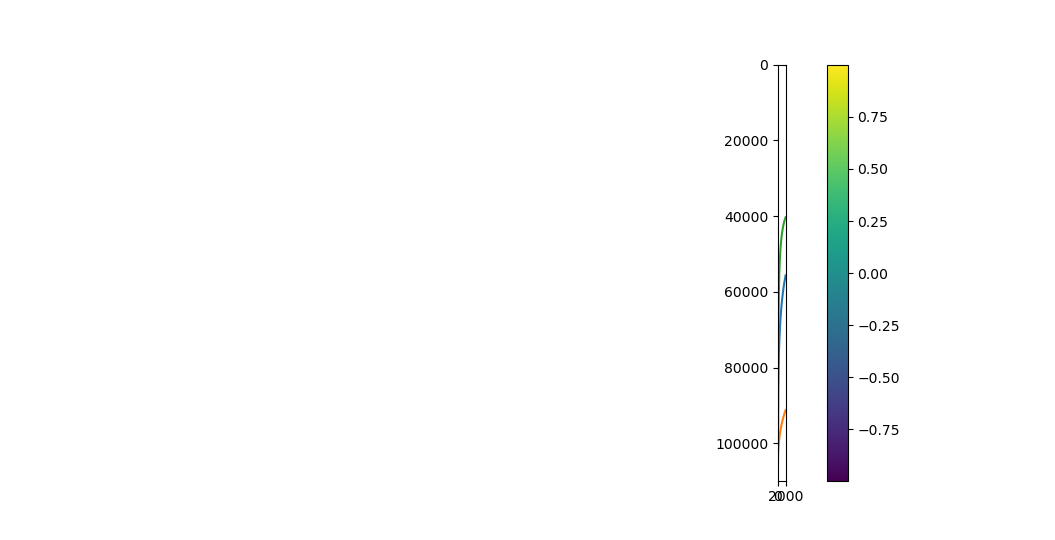

In [10]:
# create points on the sphere
n_pts = 100
theta = np.pi - np.random.rand(n_pts)
phi = 2 * np.pi - np.random.rand(n_pts)
v_initial = HemiSphere(theta=theta, phi=phi)
v_updated, potential = disperse_charges(v_initial, 2000, const=0.1)
vertices = v_updated.vertices
plt.plot(potential)
plt.show()
# angles = np.array([np.arccos(vertices[:,0]), np.arctan2(vertices[:,2],vertices[:,1])]).T

In [11]:
vertices.shape

(100, 3)

In [14]:
PHI, THETA = np.meshgrid(np.linspace(0, 2*np.pi, 20), np.linspace(0, np.pi, 10))
x = np.sin(THETA) * np.sin(PHI)
y = np.sin(THETA) * np.cos(PHI)
z = np.cos(THETA)
grid = np.stack((x, y, z), axis=0)



# find the distance of each angle to each grid point accounting for antipodal symmetry
angles_ = angles.reshape(-1,3)
grid_ = grid.reshape(3,-1)
dist = angles_ @ grid_
dist = np.arccos(dist)
labels = np.argmax(dist, axis=1)
indices, counts = np.unique(labels, return_counts=True) # indices are the bin indices, counts are the number of angles in each bin

# there are 800 bins, so there should be 800 indices unless there are bins with no angles in them.
# add 0 counts to bins with no angles in them
if len(indices) < dist.shape[1]:
    counts_ = np.zeros(dist.shape[1], dtype=np.int64)
    counts_[indices] = counts
    counts = counts_
# reshape counts to match grid shape
counts = counts.reshape(x.shape)


In [ ]:
grid[:,9,19]

In [16]:
print(grid.shape)
print(dist.shape)
print(labels.shape)
print(indices.shape)
print(counts.shape)

(3, 10, 20)
(110592, 200)
(110592,)
(156,)
(10, 20)


In [ ]:
counts

In [17]:
# fit k-means to the angles
skm = apsym_kmeans.APSymKMeans(n_clusters=1)
skm.fit(angles_)
mu = skm.cluster_centers_[0]
print(mu)


[ 0.05239102 -0.41209986  0.90963118]


NameError: name 'phantom_angle' is not defined

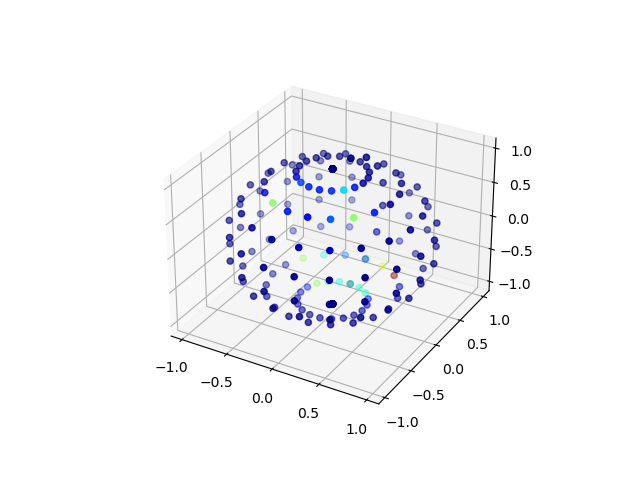

In [18]:
# plot the histogram
# weights = np.sin(THETA)
R = counts / np.max(counts)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.plot_surface(R*x, R*y, R*z, rstride=1, cstride=1, cmap=plt.get_cmap('jet'), linewidth=0, antialiased=False, alpha=0.5)
# ax.plot_surface(R*x, R*y, R*z, cmap=plt.get_cmap('jet'), linewidth=0, antialiased=False, alpha=0.5)
ax.scatter3D(x, y, z, c=R, cmap=plt.get_cmap('jet'))

t = np.linspace(-1.5, 1.5, 100)
theta = phantom_angle[0]
phi = phantom_angle[1]
i = np.sin(theta) * np.sin(phi)
j = np.sin(theta) * np.cos(phi)
k = np.cos(theta)
print(i,j,k)
ax.plot(t*i, t*j, t*k, color='k', linewidth=1)
ax.plot(t*mu[0], t*mu[1], t*mu[2], color='r', linewidth=1)





In [ ]:
R = np.ones((30,20))
R[0,0] = 2.0
R[15,10] = 2.0


ValueError: operands could not be broadcast together with shapes (10,20) (30,20) 

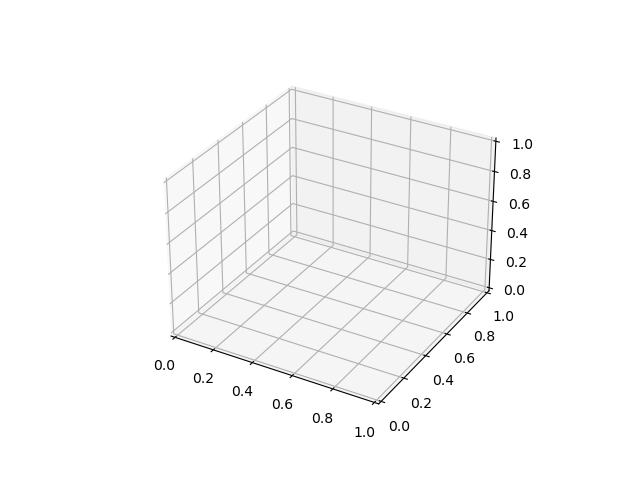

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(R*x, R*y, R*z, cmap=plt.cm.YlGnBu_r)
plt.show()